# execution on real quantum computers
## quantum neural networks experimentation

### index
1. [imports](#imports)
2. [data](#data)
3. [classical classification](#classical-classification)

### imports <a class="anchor" id="imports"></a>

In [4]:
# utils imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
# quantum imports
from qiskit_algorithms.utils import algorithm_globals
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.algorithms.regressors import VQR
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile
#constants
algorithm_globals.random_seed = 33
np.random.seed(33)
# Load IBM Quantum account
IBMQ_TOKEN = "token"

### data <a class="anchor" id="data"></a>

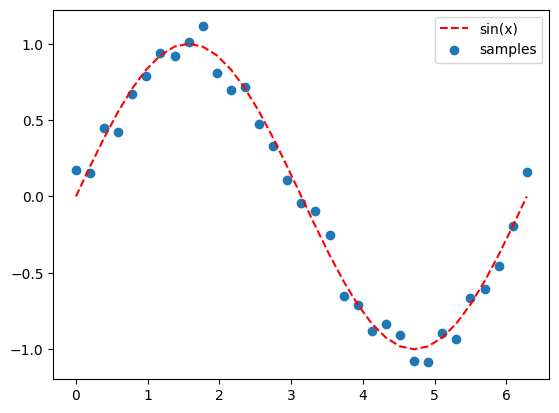

In [5]:
# we define the number of samples
n_samples = 33
x = np.linspace(0, 2 * np.pi, n_samples)
f = np.sin(x)
# we get random points from the function and add some noise
train_x = np.sort(np.random.choice(x, n_samples, replace=False))
train_y = f + 0.1 * np.random.randn(n_samples)
# we plot the function and the noisy samples
plt.plot(x, f, "r--", label="sin(x)")
plt.scatter(train_x, train_y, label="samples")
plt.legend()

c:\Users\adrfd\Desktop\4isw\tfg\quantum-neural-networks\.venv\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:267: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\adrfd\Desktop\4isw\tfg\quantum-neural-networks\.venv\Lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


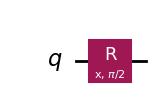

In [6]:
# we define a simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)
feature_map.decompose().draw(output="mpl", style="iqx")

c:\Users\adrfd\Desktop\4isw\tfg\quantum-neural-networks\.venv\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:267: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\adrfd\Desktop\4isw\tfg\quantum-neural-networks\.venv\Lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


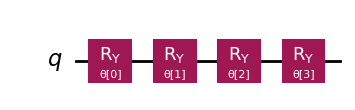

In [7]:
# we define a simple ansatz
ansatz = RealAmplitudes(1, reps=3)
ansatz.decompose().draw(output="mpl", style="iqx")

In [8]:
# we choose our optimizer algorithm
optimizer = L_BFGS_B(maxiter=10)

In [9]:
backend = GenericBackendV2(num_qubits=10, basis_gates=[ 'ecr', 'id', 'rz', 'sx', 'x'])
print(f"Selected backend: {backend}")

Selected backend: <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x000001EC50A62CF0>


In [10]:
estimator = Estimator(backend=backend)

In [11]:
transpiled_feature_map = transpile(feature_map, backend)
transpiled_ansatz = transpile(ansatz, backend)

In [12]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("objective function value against iteration")
    plt.xlabel("iteration")
    plt.ylabel("objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

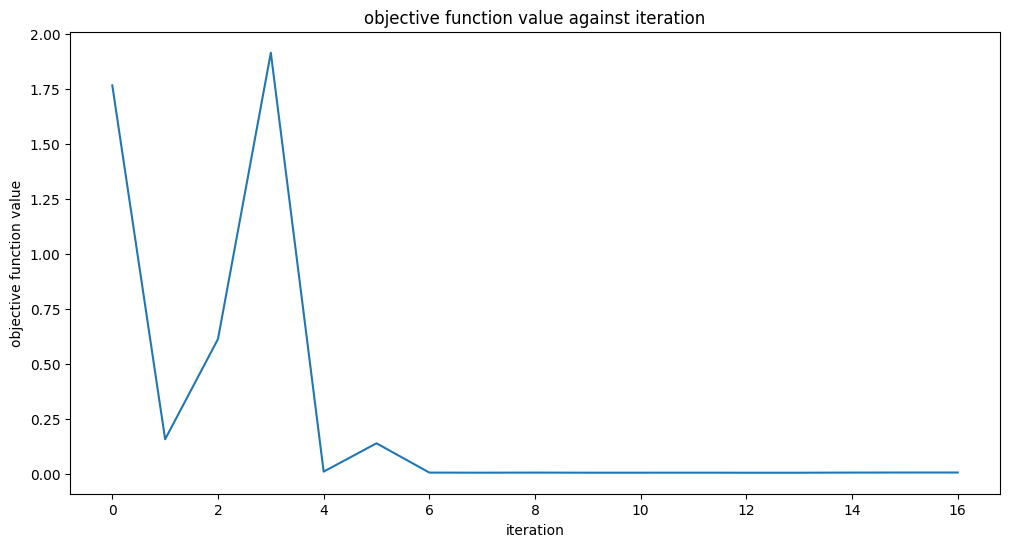

training time: 120.72 sec


In [13]:
objective_func_vals = []
# we define the variational quantum circuit
vqr = VQR(
    estimator=estimator,
    feature_map=transpiled_feature_map,
    ansatz=transpiled_ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)
start = time.time()
vqr.fit(train_x.reshape(-1,1), train_y)
end = time.time()
print(f"training time: {end-start:.2f} sec")

quantum accuracy: 0.9995357831165961


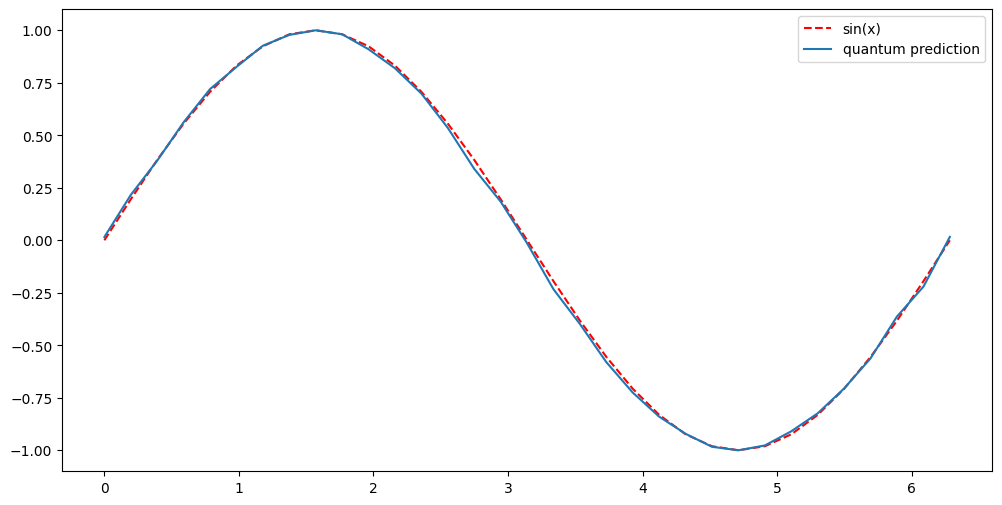

In [19]:
q_train_score = vqr.score(x.reshape(-1,1), f)

print(f"quantum accuracy: {q_train_score}")

y_predict = vqr.predict(x.reshape(-1,1))
plt.plot(x, f, "r--", label="sin(x)")
plt.plot(x, y_predict, label="quantum prediction")
plt.legend()

vqr.save("vqr_model.model")

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=IBMQ_TOKEN)
backend = service.least_busy(operational=True, simulator=False)
print(f"Selected backend: {backend}")
estimatorQ = Estimator(backend=backend)


Selected backend: <IBMBackend('ibm_osaka')>


In [16]:
vqrIBM = VQR.load("vqr_model.model")
vqrIBM.neural_network.estimator = estimatorQ

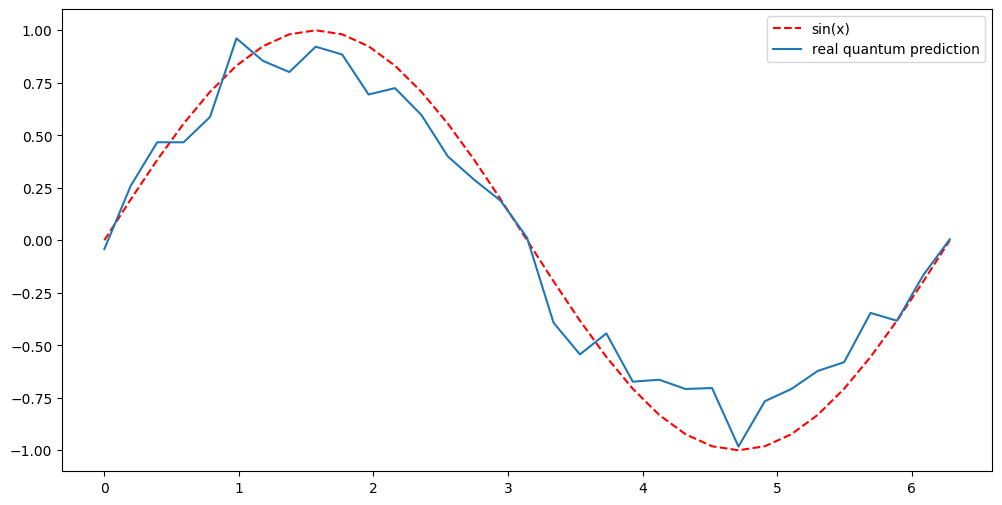

In [17]:
y_predict_q = vqrIBM.predict(x.reshape(-1,1))
plt.plot(x, f, "r--", label="sin(x)")
plt.plot(x, y_predict_q, label="real quantum prediction")
plt.legend()